In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch256',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test':

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 96
dataloaders_conf['val']['batch_size'] = 96
dataloaders_conf['test']['batch_size'] = 96
dataloaders_conf

{'train': {'batch_size': 96, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 96, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 96, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:03, 209.90it/s]
100%|██████████| 720/720 [00:07<00:00, 93.07it/s] 
33120it [00:00, 237067.83it/s]
31680it [00:00, 155716.15it/s]
700it [00:03, 220.12it/s]
100%|██████████| 700/700 [00:06<00:00, 100.57it/s]
27830it [00:00, 142691.13it/s]
26620it [00:00, 244188.74it/s]
710it [00:03, 220.71it/s]
100%|██████████| 710/710 [00:07<00:00, 97.31it/s] 
31680it [00:00, 139586.45it/s]
30240it [00:00, 128255.15it/s]
720it [00:00, 817.84it/s]
100%|██████████| 720/720 [00:07<00:00, 94.43it/s] 
33120it [00:00, 250924.11it/s]
720it [00:03, 229.90it/s]
100%|██████████| 720/720 [00:07<00:00, 95.43it/s] 
103680it [00:00, 173515.72it/s]
700it [00:03, 224.98it/s]
100%|██████████| 700/700 [00:06<00:00, 106.65it/s]
84700it [00:00, 226537.99it/s]
509it [00:01, 375.04it/s]
100%|██████████| 509/509 [00:02<00:00, 198.76it/s]
32576it [00:00, 85588.44it/s]
700it [00:02, 303.42it/s]
100%|██████████| 700/700 [00:06<00:00, 102.02it/s]
84700it [00:00, 225233.72it/s]
700it [00:00, 832.25it/s]
100%|██████████| 

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.092182


100%|██████████| 923/923 [00:32<00:00, 28.40it/s]


Mean val loss: 0.060459


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.034007


100%|██████████| 923/923 [00:32<00:00, 28.27it/s]


Mean val loss: 0.046641


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.030227


100%|██████████| 923/923 [00:32<00:00, 28.38it/s]


Mean val loss: 0.028783


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.028551


100%|██████████| 923/923 [00:32<00:00, 28.28it/s]


Mean val loss: 0.027883


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.027596


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.033376
EarlyStopping counter: 1 out of 15
Epoch 5...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.026946


100%|██████████| 923/923 [00:32<00:00, 28.40it/s]


Mean val loss: 0.026434


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.026395


100%|██████████| 923/923 [00:32<00:00, 28.23it/s]


Mean val loss: 0.026019


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.025755


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.032133
EarlyStopping counter: 1 out of 15
Epoch 8...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.025609


100%|██████████| 923/923 [00:32<00:00, 28.24it/s]


Mean val loss: 0.025636


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.025362


100%|██████████| 923/923 [00:32<00:00, 28.20it/s]


Mean val loss: 0.025294


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.024794


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.025525
EarlyStopping counter: 1 out of 15
Epoch 11...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.024604


100%|██████████| 923/923 [00:32<00:00, 28.05it/s]


Mean val loss: 0.024776


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.024257


100%|██████████| 923/923 [00:32<00:00, 28.24it/s]


Mean val loss: 0.024517


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.024123


100%|██████████| 923/923 [00:32<00:00, 28.35it/s]


Mean val loss: 0.024238


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.023891


100%|██████████| 923/923 [00:32<00:00, 28.32it/s]


Mean val loss: 0.024145


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.023691


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.024788
EarlyStopping counter: 1 out of 15
Epoch 16...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.023586


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.026391
EarlyStopping counter: 2 out of 15
Epoch 17...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.023484


100%|██████████| 923/923 [00:32<00:00, 28.02it/s]


Mean val loss: 0.02366


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02319


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.025151
EarlyStopping counter: 1 out of 15
Epoch 19...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02318


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.024038
EarlyStopping counter: 2 out of 15
Epoch 20...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02315


100%|██████████| 923/923 [00:32<00:00, 28.19it/s]


Mean val loss: 0.023573


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.023036


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.024343
EarlyStopping counter: 1 out of 15
Epoch 22...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022802


100%|██████████| 923/923 [00:32<00:00, 28.23it/s]


Mean val loss: 0.023248


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022734


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023479
EarlyStopping counter: 1 out of 15
Epoch 24...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022661


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.02326
EarlyStopping counter: 2 out of 15
Epoch 25...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022467


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023415
EarlyStopping counter: 3 out of 15
Epoch 26...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022554


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023362
EarlyStopping counter: 4 out of 15
Epoch 27...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02243


100%|██████████| 923/923 [00:32<00:00, 28.33it/s]


Mean val loss: 0.023136


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 28...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022322


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023675
EarlyStopping counter: 1 out of 15
Epoch 29...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022246


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023451
EarlyStopping counter: 2 out of 15
Epoch 30...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022183


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023173
EarlyStopping counter: 3 out of 15
Epoch 31...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022143


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023352
EarlyStopping counter: 4 out of 15
Epoch 32...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022039


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023669
EarlyStopping counter: 5 out of 15
Epoch 33...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022101


100%|██████████| 923/923 [00:32<00:00, 28.18it/s]


Mean val loss: 0.022539


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.022022


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.025636
EarlyStopping counter: 1 out of 15
Epoch 35...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021874


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022646
EarlyStopping counter: 2 out of 15
Epoch 36...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021887


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023201
EarlyStopping counter: 3 out of 15
Epoch 37...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021824


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023723
EarlyStopping counter: 4 out of 15
Epoch 38...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021851


100%|██████████| 923/923 [00:32<00:00, 28.29it/s]


Mean val loss: 0.022494


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021745


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022701
EarlyStopping counter: 1 out of 15
Epoch 40...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021667


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.024365
EarlyStopping counter: 2 out of 15
Epoch 41...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021689


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.024812
EarlyStopping counter: 3 out of 15
Epoch 42...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021641


100%|██████████| 923/923 [00:32<00:00, 28.28it/s]


Mean val loss: 0.02234


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021617


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022666
EarlyStopping counter: 1 out of 15
Epoch 44...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021569


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023462
EarlyStopping counter: 2 out of 15
Epoch 45...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021591


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022562
EarlyStopping counter: 3 out of 15
Epoch 46...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021482


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022646
EarlyStopping counter: 4 out of 15
Epoch 47...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021418


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022672
EarlyStopping counter: 5 out of 15
Epoch 48...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021441


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022402
EarlyStopping counter: 6 out of 15
Epoch 49...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021369


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023971
EarlyStopping counter: 7 out of 15
Epoch 50...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021361


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022597
EarlyStopping counter: 8 out of 15
Epoch 51...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021311


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022838
EarlyStopping counter: 9 out of 15
Epoch 52...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02119


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023139
EarlyStopping counter: 10 out of 15
Epoch 53...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021215


100%|██████████| 923/923 [00:33<00:00, 27.56it/s]


Mean val loss: 0.022285


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 54...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021211


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.0225
EarlyStopping counter: 1 out of 15
Epoch 55...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021229


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022542
EarlyStopping counter: 2 out of 15
Epoch 56...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02111


100%|██████████| 923/923 [00:32<00:00, 28.11it/s]


Mean val loss: 0.022197


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 57...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021071


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022334
EarlyStopping counter: 1 out of 15
Epoch 58...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021052


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.029184
EarlyStopping counter: 2 out of 15
Epoch 59...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.021032


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022561
EarlyStopping counter: 3 out of 15
Epoch 60...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020973


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023905
EarlyStopping counter: 4 out of 15
Epoch 61...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020953


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022776
EarlyStopping counter: 5 out of 15
Epoch 62...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020926


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022245
EarlyStopping counter: 6 out of 15
Epoch 63...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020875


100%|██████████| 923/923 [00:32<00:00, 28.24it/s]


Mean val loss: 0.022094


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 64...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02088


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022308
EarlyStopping counter: 1 out of 15
Epoch 65...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020877


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022171
EarlyStopping counter: 2 out of 15
Epoch 66...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020861


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022874
EarlyStopping counter: 3 out of 15
Epoch 67...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020852


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022286
EarlyStopping counter: 4 out of 15
Epoch 68...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020732


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023997
EarlyStopping counter: 5 out of 15
Epoch 69...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020796


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022392
EarlyStopping counter: 6 out of 15
Epoch 70...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020682


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022299
EarlyStopping counter: 7 out of 15
Epoch 71...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020671


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022221
EarlyStopping counter: 8 out of 15
Epoch 72...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020673


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022676
EarlyStopping counter: 9 out of 15
Epoch 73...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020584


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023981
EarlyStopping counter: 10 out of 15
Epoch 74...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020578


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023773
EarlyStopping counter: 11 out of 15
Epoch 75...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020589


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.02212
EarlyStopping counter: 12 out of 15
Epoch 76...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020517


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.027293
EarlyStopping counter: 13 out of 15
Epoch 77...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020528


100%|██████████| 923/923 [00:32<00:00, 28.13it/s]


Mean val loss: 0.021986


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 78...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020493


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022678
EarlyStopping counter: 1 out of 15
Epoch 79...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02044


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023738
EarlyStopping counter: 2 out of 15
Epoch 80...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.0204


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023201
EarlyStopping counter: 3 out of 15
Epoch 81...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020352


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022895
EarlyStopping counter: 4 out of 15
Epoch 82...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020371


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022132
EarlyStopping counter: 5 out of 15
Epoch 83...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02038


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022454
EarlyStopping counter: 6 out of 15
Epoch 84...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020336


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.02738
EarlyStopping counter: 7 out of 15
Epoch 85...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020291


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.02244
EarlyStopping counter: 8 out of 15
Epoch 86...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020292


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022051
EarlyStopping counter: 9 out of 15
Epoch 87...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020228


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023886
EarlyStopping counter: 10 out of 15
Epoch 88...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020259


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.023674
EarlyStopping counter: 11 out of 15
Epoch 89...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020204


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.025914
EarlyStopping counter: 12 out of 15
Epoch 90...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020199


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.028015
EarlyStopping counter: 13 out of 15
Epoch 91...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.020136


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.022674
EarlyStopping counter: 14 out of 15
Epoch 92...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.02015


  0%|          | 0/345 [00:00<?, ?it/s]

Mean val loss: 0.022711
EarlyStopping counter: 15 out of 15


100%|██████████| 883/883 [07:05<00:00,  2.07it/s]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

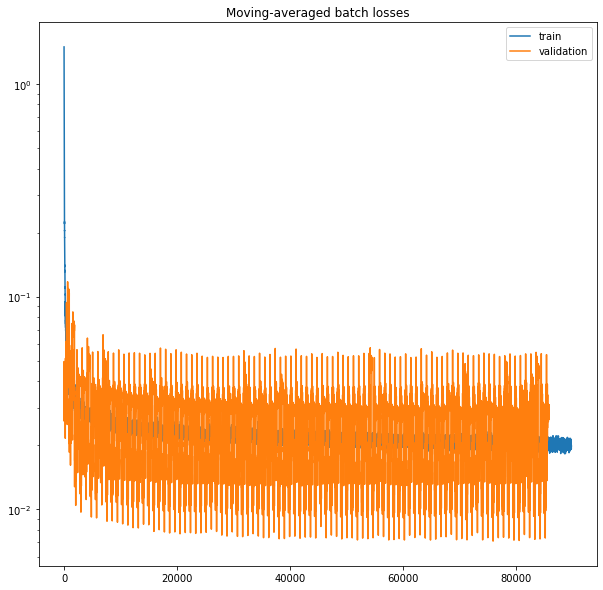

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

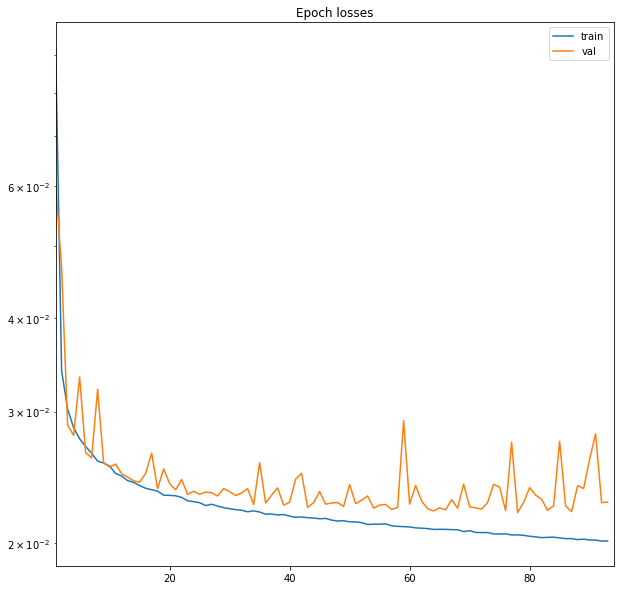

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996195,0.954563,0.996998,0.975319,0.998863,0.951827,carb96558,basic
1,0.984487,0.890024,0.996534,0.940272,0.977203,0.887277,carb71,basic
2,0.981567,0.943568,0.924136,0.933751,0.974076,0.875735,carbRNF,basic
3,0.993729,0.989474,0.942472,0.965401,0.992830,0.933116,SPE_carb10_58_box3,basic
4,0.992397,0.961130,0.943370,0.952167,0.993367,0.908701,SoilAh-1,basic
5,0.992964,0.952287,0.996420,0.973854,0.999018,0.949040,SoilB-2,basic
6,0.990082,0.994479,0.937330,0.965059,0.981212,0.932478,TeTree_subset1,basic
7,0.994364,0.993861,0.953474,0.973248,0.986008,0.947891,TiTree_subset2,basic
8,0.991275,0.939336,0.996624,0.967133,0.998059,0.936357,Urna_22,basic
9,0.990016,0.952398,0.988619,0.970170,0.997818,0.942069,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92476
Std    IOU: 0.026021
Min    IOU: 0.87573
Median IOU: 0.93312


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0092
Mean 1 loss: 0.0039
Mean of ratios: 2.5252
Ratio of means: 2.3247
